In [1]:
import torch

from src.modelling.production import FootPrintModel, UnetMOCO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_moco = UnetMOCO("../artifacts/weights/Unet_rn50_MOCO.pth", device)
footprint_model = FootPrintModel(device="cuda")

In [14]:
from src.modelling.ensemble import Ensemble

ensemble = Ensemble(models={
    "unet": unet_moco,
    "footprint": footprint_model
})

In [15]:
from src.preprocessing.reader import Reader

r = Reader("../data/digital_leaders", read_type="opencv")
image, mask = r.read_sample(1)
print(image.shape, mask.shape)

(3824, 5973, 3) (3824, 5973)


In [16]:
import numpy as np
import matplotlib.pyplot as plt


def random_crop(image, mask, size):
    h, w = image.shape[:2]
    new_h, new_w = size
    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)
    image = image[top: top + new_h, left: left + new_w]
    mask = mask[top: top + new_h, left: left + new_w]
    return image, mask


def show_results(image_tile, mask_tile, binary_pred):
    plt.subplots(2, 3, figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(image_tile)
    plt.title("image")
    plt.subplot(2, 3, 2)
    plt.imshow(mask_tile * 255, cmap='Reds')
    plt.title("mask")
    plt.subplot(2, 3, 3)
    plt.imshow(binary_pred * 255, cmap='Reds')
    plt.title("prediction")
    plt.subplot(2, 3, 4)
    plt.imshow(np.abs(binary_pred - mask_tile) * 255, cmap='Reds')
    plt.title("diff")
    plt.subplot(2, 3, 5)
    plt.imshow(image_tile)
    plt.imshow(mask_tile * 255, cmap='Reds', alpha=0.5)
    plt.title("image + mask")
    plt.subplot(2, 3, 6)
    plt.imshow(image_tile)
    plt.imshow(binary_pred * 255, cmap='Reds', alpha=0.5)
    plt.title("image + prediction")
    plt.show()


def show_random_crop_results(image, mask):
    image_tile, mask_tile = random_crop(image, mask, (512, 512))
    pred_tile = ensemble(image_tile, return_average=True)

    threshold = 0.5
    binary_pred = (pred_tile > threshold).astype(np.int16)
    mask_tile = mask_tile.astype(np.int16)

    show_results(image_tile, mask_tile, binary_pred)

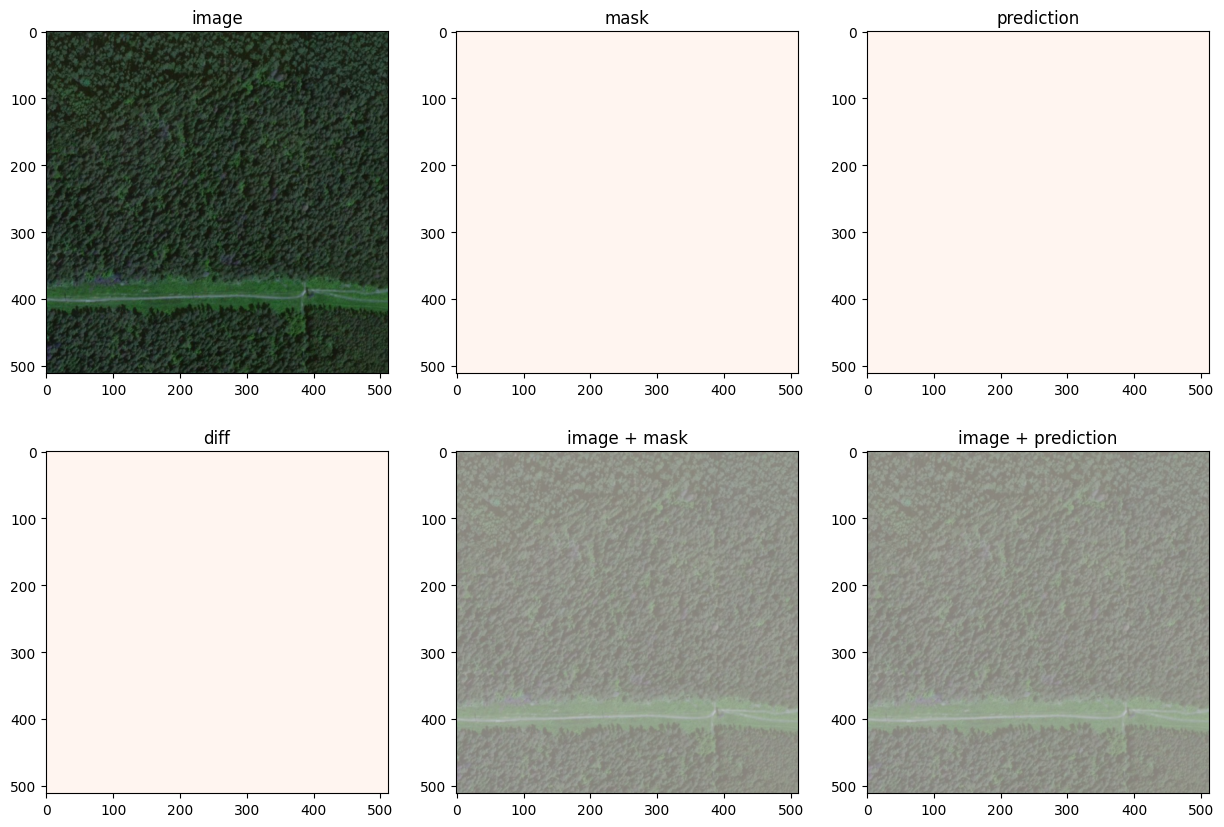

In [26]:
show_random_crop_results(image, mask)